# RNAseq PCA

Notebook for performing PCA on the feature count files.

2020-09-14

## Initial boilerplate

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = ''
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

## 1. Loading data

We load the outputs from featureCounts:

In [2]:
import pandas as pd

data_file_names = []
data_file_names.append("featureCounts_on_Control1.tabular")
data_file_names.append("featureCounts_on_Control4.tabular")
data_file_names.append("featureCounts_on_Control5.tabular")
data_file_names.append("featureCounts_on_KCl2.tabular")
data_file_names.append("featureCounts_on_KCl3.tabular")
data_file_names.append("featureCounts_on_KCl4.tabular")
data_file_names.append("featureCounts_on_NaCl1.tabular")
data_file_names.append("featureCounts_on_NaCl2.tabular")
data_file_names.append("featureCounts_on_NaCl3.tabular")

feature_counts = pd.DataFrame()
for data_file_name in data_file_names:
    full_name = join(INTERMEDIATE,data_file_name)
    new_data = pd.read_csv(full_name, index_col=0, sep="\t")
    new_data.columns = [new_data.columns[0].replace("RNA STAR on ","").replace(": mapped.bam","")]
    if feature_counts.empty:
        feature_counts = new_data
    else:
        feature_counts = pd.merge(feature_counts, new_data, left_index=True, right_index=True)

# transpose data (variables should be the genes)
feature_counts = feature_counts.transpose()
feature_counts

Geneid,gene-DEHA2A00110g,gene-DEHA2A00132g,gene-DEHA2A00154g,gene-DEHA2A00176g,gene-DEHA2A00198g,gene-DEHA2A00220g,gene-DEHA2A00242g,gene-DEHA2A00264g,gene-DEHA2A00286g,gene-DEHA2A00308g,...,rna-NC_010166.1:18922..18994,rna-NC_010166.1:18995..19066,rna-NC_010166.1:19069..19139,rna-NC_010166.1:19140..19223,rna-NC_010166.1:19228..19308,rna-NC_010166.1:25973..26055,rna-NC_010166.1:26058..26137,rna-NC_010166.1:27648..27719,rna-NC_010166.1:27763..27833,gene-SSU
Control1,172,54,17157,107,284,810,1504,972,2203,273,...,0,0,0,0,0,0,0,0,0,263
Control4,557,227,20856,143,417,885,2207,1183,2365,326,...,0,0,0,0,0,0,0,0,1,250
Control5,487,188,19692,97,431,1169,2380,1208,4049,275,...,0,0,0,1,0,0,0,0,0,232
1MKCl2,44,30,17471,94,351,344,787,720,2053,347,...,0,0,0,0,0,0,0,0,0,648
1MKCl3,71,30,24301,102,519,561,2262,1037,2230,387,...,0,0,0,0,0,0,0,0,0,590
1MKCl4,18,17,10478,99,392,375,807,632,2086,204,...,0,0,0,0,0,0,0,0,0,28
1MNaCl1,85,54,19806,86,584,715,2383,1116,3942,280,...,0,0,0,0,0,0,0,0,0,285
1MNaCl2,75,53,20211,75,506,574,1675,836,2212,313,...,0,0,0,0,0,0,0,0,1,125
1MNaCl3,72,44,16215,99,521,710,2521,1242,3116,271,...,0,0,0,0,0,0,0,0,1,332


In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# normalize the data:
x = feature_counts.loc[:, ].values
x = StandardScaler().fit_transform(x)

# run PCA:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

#transform PCA results to dataframe
pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
pca_df.index = feature_counts.index
groups = ["Control", "KCl", "NaCl"]
for (idx, row) in pca_df.iterrows():
    for group in groups:
        if group in idx:
            pca_df.loc[idx,"group"] = group
pca_df

,PC1,PC2,group
Control1,-22.882389,77.221103,Control
Control4,-44.238922,12.201360,Control
Control5,-68.199981,20.637992,Control
1MKCl2,82.536243,7.806888,KCl
1MKCl3,-23.818933,-25.000709,KCl
1MKCl4,88.989380,19.181140,KCl
1MNaCl1,-16.626738,-53.971974,NaCl
1MNaCl2,12.855041,-29.349447,NaCl
1MNaCl3,-8.613702,-28.726352,NaCl


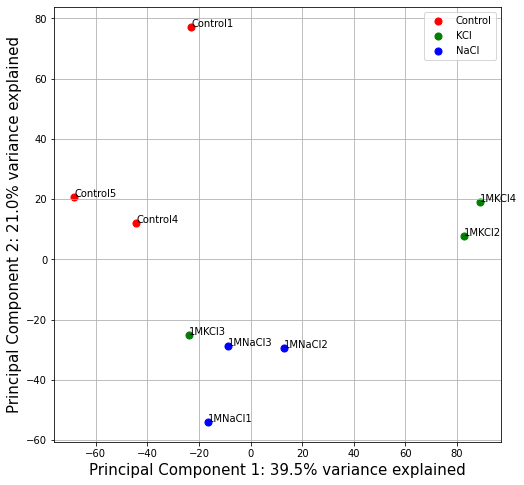

In [4]:
# get % of variability from each component
exp_var_1 = round(pca.explained_variance_ratio_[0]*100, 1)
exp_var_2 = round(pca.explained_variance_ratio_[1]*100, 1)

# plot results
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(f'Principal Component 1: {exp_var_1}% variance explained', fontsize = 15)
ax.set_ylabel(f'Principal Component 2: {exp_var_2}% variance explained', fontsize = 15)
colors = ['r', 'g', 'b']
for group, color in zip(groups,colors):
    to_keep = pca_df['group'] == group
    ax.scatter(pca_df.loc[to_keep, 'PC1'], pca_df.loc[to_keep, 'PC2'], c = color, s = 50)
ax.legend(groups)
for (idx, row) in pca_df.iterrows():
    ax.text(row["PC1"], row["PC2"], idx)
ax.grid()